# Capstone Project: Skin Lesion Classification and Diagnosis
## Notebook 2: Image Preprocessing

In this notebook, we will be implementing various image preprocessing methods to our dataset.

### Table of Contents
- [Problem Statement](#Problem-Statement)
- [Importing Libraries](#Importing-Libraries)
- [Loading CSV](#Loading-CSV)
- [Image Preprocessing](#Image-Preprocessing)
- [Image Preprocessing Functions](#Image-Preprocessing-Functions)
- [Execute Image Preprocessing](#Execute-Image-Preprocessing)
- [Visualising Preprocessed Images](#Visualising-Preprocessed-Images)

### Problem Statement

Skin cancer is the most common cancer globally, with melanoma being the most deadly form. Even though dermoscopy, a skin imaging modality, has demonstrated improvement for the diagnosis of skin cancer compared to unaided visual inspection<sup>[[1]](https://challenge2019.isic-archive.com/)</sup>, numerous cases of benign lesions are still being diagnosed as malicious and vice versa<sup>[[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6394090/)</sup>. Every year, poor diagnostic errors adds an estimated $673 million in overall cost to manage the disease<sup>[[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543387/)</sup>.

In this project, we aim to improve the diagnostic rate of skin cancer through the classification of skin lesions for dermatologists working at hospitals or skin cancer clinics in Singapore, who will need experience or expertise in diagnosing skin cancer before they can accurately identify and diagnose lesions upon visual and dermoscopy inspection<sup>[[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543387/)</sup>. This will be done through the classification of skin lesion dermoscopy images, in which we will predict two important tasks through the usage of Convolutional Neural Network models: <br>
1. a specific skin lesion diagnosis, and <br>
2. whether the lesion is malignant, benign, or pre-cancerous. <br>

The model will be evaluated based on its accuracy, followed by its recall rate since we are looking to minimise false negatives. Ultimately, we aim to get as close to a real evaluation of a dermatologist as possible: predicting the type of skin lesion; and whether the lesion is malignant, pre-cancerous or benign from dermoscopy images. With our models, we hope to aid dermatologists in their decision-making process of diagnosing skin lesions, hence allowing them to improve their diagnostic accuracy and come up with appropriate treatments for patients with skin lesions and/or cancers.

### Importing Libraries

In [1]:
#loading libraries
import cv2
import keras
import os

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow as tf
from glob import glob
import imageio

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Loading CSV

In [2]:
#load in labeled_ground_truth
all_labels = pd.read_csv('../datasets/labeled_ground_truth.csv')

In [3]:
all_labels.head(5)

,image,mel,nv,bcc,akiec,bkl,df,vasc,lesion,diagnosis,benign,malignant,precancerous
0,DERM_001,0,0,0,0,0,1,0,df,benign,1,0,0
1,DERM_002,0,0,0,0,0,1,0,df,benign,1,0,0
2,DERM_003,0,0,0,0,0,1,0,df,benign,1,0,0
3,DERM_004,0,0,0,0,0,1,0,df,benign,1,0,0
4,DERM_005,0,0,0,0,0,1,0,df,benign,1,0,0


## Image Preprocessing

The image preprocessing methods will be done in the following order:
1. Reducing the dimensions of large images by 45% (keeping 55% of original dimensions) so that preprocessing can be more efficient for these images
2. Colour normalisation of images using white balancing grey world technique
3. Removal of black hair and markings on images through morphological filtering and inpaint (image interpolation)
4. Padding images that lacks 1:1 aspect ratio
5. Utilising central crop on all images to remove some of the padding created in step 4 and any black round borders/padding that existed in the original image
6. Resizing images to make all image sizes uniform

### Image Preprocessing Functions

In [4]:
#resize by -45% for large images
#so that preprocessing would be more efficient and faster for these large images
def resize_large(img):
    scale_percent = 55 #percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    #resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [5]:
#Colour normalisation - using white balancing grey world technique
#credits: https://gist.github.com/shunsukeaihara/4603234
#https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.634.5677&rep=rep1&type=pdf

def normalise_colour(img):
    #convert from shape (0,1,2) to (2,0,1) to get each channel's values in each row
    img = img.transpose(2, 0, 1).astype(np.uint32)
    
    #get green channel's average
    mu_g = np.average(img[1])
    
    #pixel value of red channel is scaled by (the green average divided by red channel's mean)
    img[0] = np.minimum(img[0]*(mu_g/np.average(img[0])),255)
    
    #pixel value of blue channel is scaled by (the green average divided by blue channel's mean)
    img[2] = np.minimum(img[2]*(mu_g/np.average(img[2])),255)
    
    #convert back to original shape
    return img.transpose(1, 2, 0).astype(np.uint8)

In [6]:
#Black hair and markings removal
#Credits: https://github.com/sunnyshah2894/DigitalHairRemoval/blob/master/DigitalHairRemoval.py
def remove_hair(img):
    
    #Convert the original image to grayscale
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #create structural element for morphological filtering
    structural_element = cv2.getStructuringElement(1,(20,20))

    #Perform black top-hat filtering on the grayscale image to find hair/marking contours
    blackhat = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, structural_element)

    #intensify the contours in preparation for the inpainting algorithm
    ret,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    #inpaint (image interpolation) the original image depending on the mask
    image = cv2.inpaint(img,thresh2,3,cv2.INPAINT_TELEA)
    
    return image

In [7]:
#to convert all images to aspect ratio of 1:1, and then central crop them
def padding_and_crop(img):
    
    #execute padding if height and width are not the same (lacks 1:1 aspect ratio)
    if img.shape[0] != img.shape[1]:
        
        #calculate amount of padding required
        padding = round(abs(img.shape[0] - img.shape[1])/2)
        
        #add padding to height if image's height < width
        if img.shape[0] < img.shape[1]:
            img = cv2.copyMakeBorder(img, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
            
        #add padding to width if image's width < height
        elif img.shape[1] < img.shape[0]:
            img = cv2.copyMakeBorder(img, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=(0,0,0))
        
        #crop central to remove some of the padding that was either created or already present in the image
        img = tf.image.central_crop(img, 0.85) 
    
    else:
        #crop central to the other images
        #to remove some of the padding/borders that were present in the original images
        img = tf.image.central_crop(img, 0.85)
        
    return img

In [8]:
#create image preprocessing function
def preprocessing(name):
    img = image.load_img('../datasets/image_dataset/' + name + '.jpg')
    img = img_to_array(img).astype(np.uint8)
    
    #resize large images (keeping aspect ratio) by -45%
    if (img.shape[0] > 1500) and (img.shape[1] > 1500):
        img = resize_large(img)
    
    #remove hair and markings
    img = remove_hair(img)

    #colour normalisation
    img = normalise_colour(img)
    
    #to make all images with 1:1 aspect ratio
    #and central crop all images
    img = padding_and_crop(img)
    
    #resize and save image as 380x380 
    img = tf.image.resize(img,(380,380), method='bilinear')
    img = image.array_to_img(img)
    
    #save the newly processed image
    imageio.imwrite("../datasets/processed_image/"+ name + '.jpg', img)
    return img

### Execute Image Preprocessing

In [ ]:
# #Run this code to create new sub-directory called 'processed_image'
# directory = "processed_image"
# parent_dir = os.getcwd() + '/datasets'
# path = os.path.join(parent_dir, directory) 
  
# #Create the sub-directory 'processed_image' in parent dir 
# os.mkdir(path) 
# print("Directory '%s' created" %directory) 

In [ ]:
#Run this to preprocess images and then save it in 'processed_image' folder

#tdqm shows current status of image loading
for i in tqdm_notebook(all_labels['image']):
    preprocessing(i)

In [7]:
#download link for preprocessed images: https://bit.ly/processed_image

#check for the number of preprocessed images
filelist = glob("../datasets/processed_image/*_*.jpg")
len(filelist)

10276

### Visualising Preprocessed Images

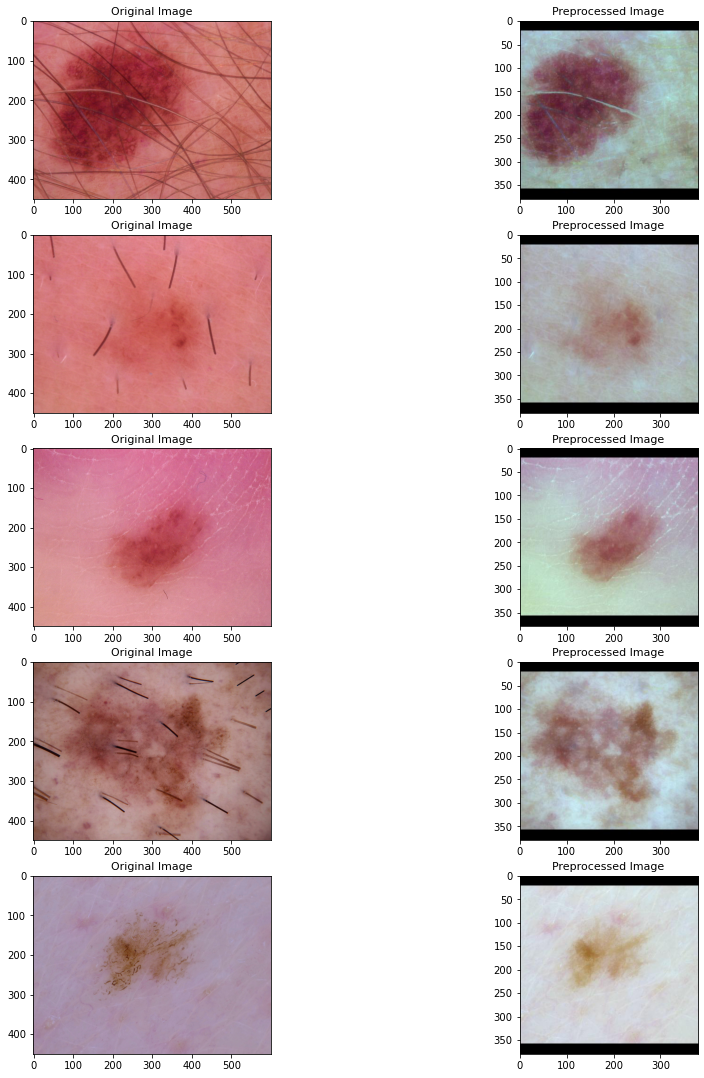

In [9]:
#plot to compare original images with preprocessed images
image_ids = all_labels['image']

plt.figure(figsize = (15,19))
count = 1
for img_id in image_ids[35:40]: #plot 5 images
    img = load_img('../datasets/image_dataset/'+ img_id + '.jpg')
    plt.subplot(5,2, count)
    plt.imshow(img)
    plt.title('Original Image', fontsize=11)

    img = load_img('../datasets/processed_image/'+ img_id + '.jpg')
    plt.subplot(5,2, count+1)
    plt.imshow(img)
    plt.title('Preprocessed Image', fontsize=11)
    
    count = count + 2

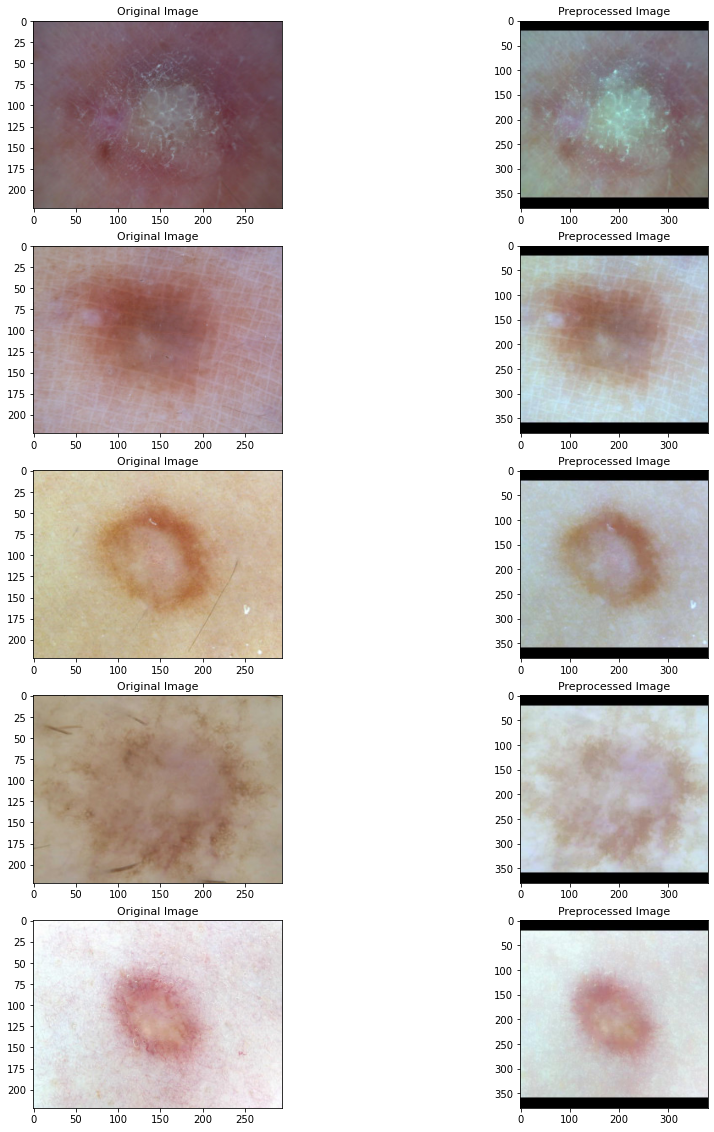

In [11]:
#plot to compare original images with pre-processed images

plt.figure(figsize = (15,20))
count = 1
for img_id in image_ids[:5]: #plot first 5 images
    img = load_img('../datasets/image_dataset/'+ img_id + '.jpg')
    plt.subplot(5,2, count)
    plt.imshow(img)
    plt.title('Original Image', fontsize=11)

    img = load_img('../datasets/processed_image/'+ img_id + '.jpg')
    plt.subplot(5,2, count+1)
    plt.imshow(img)
    plt.title('Preprocessed Image', fontsize=11)
    
    count = count + 2